## Packages

In [ ]:
import sklearn
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Part I

#### Import csv files

In [ ]:
# Import the data
tree = pd.read_csv('tree.csv')
tree['t'] = tree['t'].replace(to_replace=0, value=0.0001)

vert_genes = pd.read_csv('vert_genes.csv')

,Parent,Child,age_ch,t,species
0,222.0,1,0.000000,9.000250,Peromyscus_maniculatus
1,222.0,2,0.000000,9.000250,Mus_musculus
2,221.0,3,0.000000,12.172706,Cricetulus_griseus
3,220.0,4,0.000000,14.684269,Rattus_norvegicus
4,219.0,5,0.000000,17.062881,Mesocricetus_auratus
...,...,...,...,...,...
402,399.0,403,7.861905,1.640772,NaN
403,403.0,404,5.750020,2.111885,NaN
404,404.0,405,5.500000,0.250020,NaN
405,403.0,406,5.000000,2.861905,NaN


In [ ]:
# Creating the graph

def create_graph(tree, alpha = 0.4, beta = 1, sigma_sq = 2500):
    G = nx.DiGraph()
    for _, row in tree.iterrows():
        if not pd.isna(row['Parent']):
            G.add_edge(int(row["Parent"]), int(row["Child"]), time = row["t"], a = alpha*row["t"], b = beta, variance = sigma_sq*row["t"])
            
    return G

G = create_graph(tree)

#### Plots

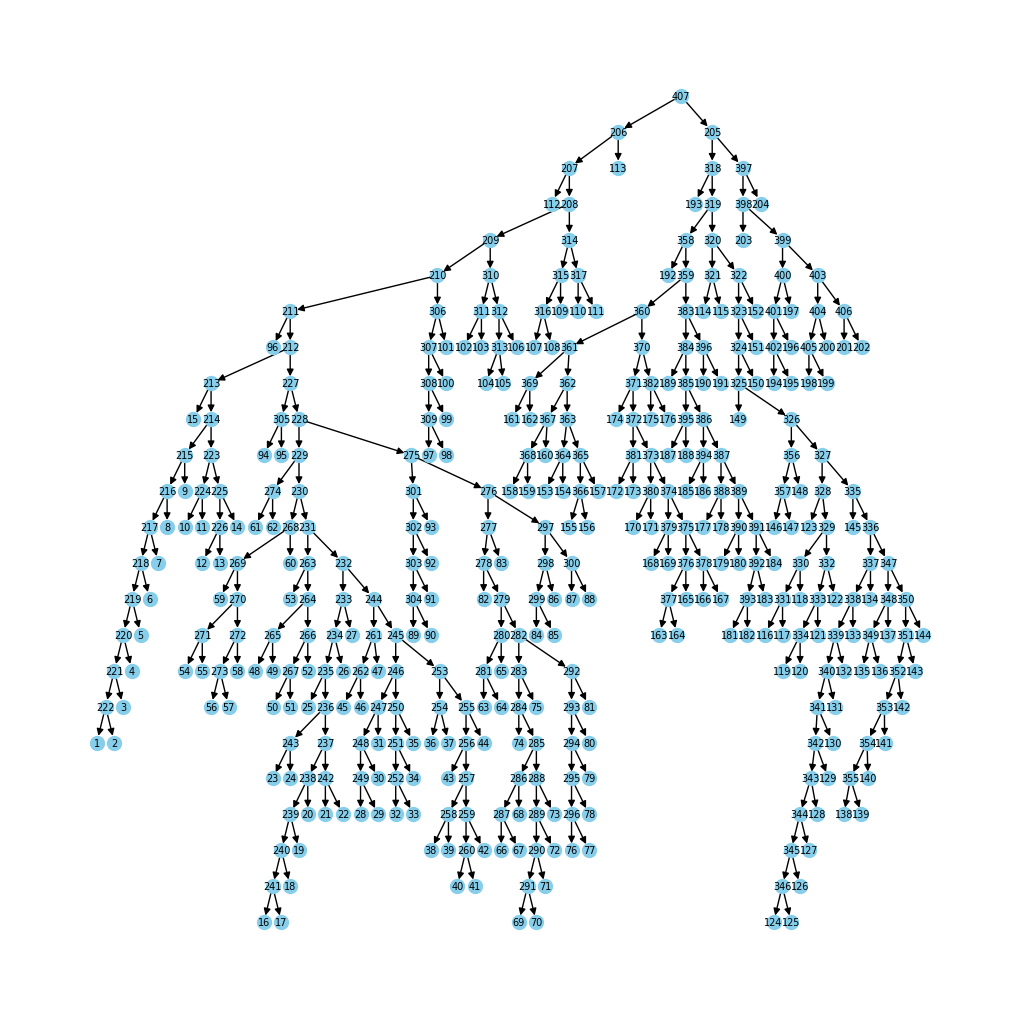

In [31]:
# Plot the graph as a top-down tree
plt.figure(figsize=(10, 10))
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True, font_size = 7, node_color = "Skyblue", node_size = 100)
plt.show()

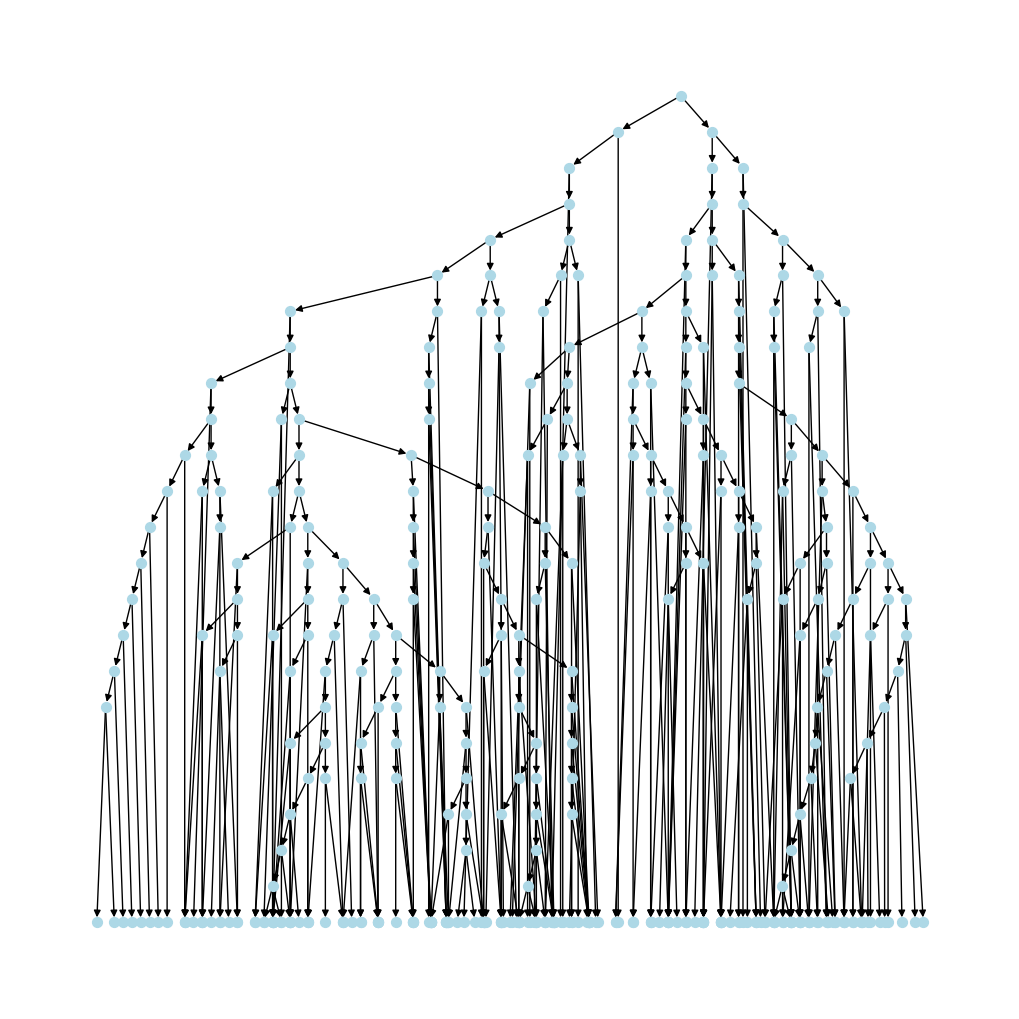

In [ ]:
# Get initial layout
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")

nodes = list(G.nodes)

# Find leaf nodes (nodes with no outgoing edges)
leaves = [node for node in nodes if G.out_degree(node) == 0]

# Find minimum depth of the tree
min_depth = min(pos[node][1] for node in pos)  # Highest Y value

# Adjust leaf positions to be at min_depth
for leaf in leaves:
    pos[leaf] = (pos[leaf][0], min_depth)

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=False, node_size=50, node_color="lightblue", edge_color="black")
plt.show()

#### Simulations

In [33]:
# Parameters
alpha_0 = 50000
alpha = 0.5
sigma_0_sq = 5000
sigma_sq = 2500
beta = 1

# Simulate length of root node
root = 407

# Function to simulate the length of a node
def simulate_node_length(parent, simulated_lengths):
    for child in G.successors(parent):
        t = G[parent][child]['time']
        mean = alpha * t + beta * simulated_lengths[parent]
        std = np.sqrt(sigma_sq * t)
        simulated_lengths[child] = np.random.normal(mean, std)
        simulate_node_length(child, simulated_lengths)
    
    return simulated_lengths

In [34]:
n = 1000

def simulate_data(n):
    

    X_values = []
    Y_values = []

    leaf_nodes = [node for node in G.nodes if G.out_degree(node) == 0]

    for i in range(n):
        simulated_lengths = {}
        simulated_lengths[root] = np.random.normal(alpha_0, np.sqrt(sigma_0_sq))
        simulated_lengths = simulate_node_length(root, simulated_lengths)

        simulated_x = [simulated_lengths[node] for node in leaf_nodes]
        X_values.append(simulated_x)
        Y_values.append(simulated_lengths[root])

    return(np.array(X_values), np.array(Y_values))

X_values, Y_values = simulate_data(n)

print(X_values.shape)
print(Y_values.shape)

(1000, 204)
(1000,)


In [35]:
print(Y_values[0])

50034.720283897754


#### Linear regression model

In [37]:
model = LinearRegression()

X_train, X_test, Y_train, Y_test = train_test_split(X_values, Y_values, test_size = 0.2)
model.fit(X_train, Y_train)

slope = model.coef_
intercept = model.intercept_

# print(slope)
# print(intercept)

Y_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2: {r2}")


Mean Absolute Error: 57.833135810967946
Mean Squared Error: 5357.423033301123
Root Mean Squared Error: 73.19441941364876
R^2: 0.10085028585627032


#### Linear regression plots

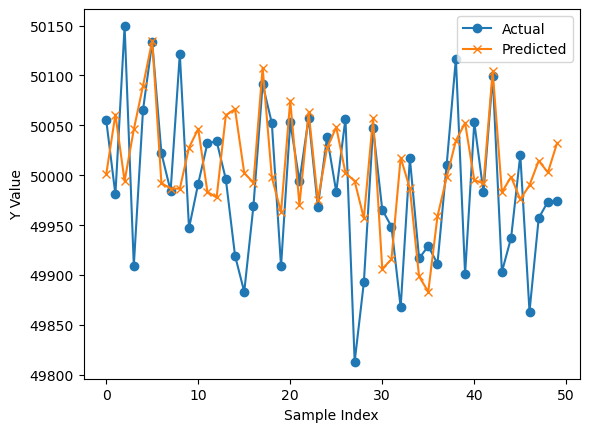

In [38]:
points = 50

plt.plot(Y_test[:points], label="Actual", marker='o')  # First 100 values
plt.plot(Y_pred[:points], label="Predicted", marker='x')
plt.xlabel("Sample Index")
plt.ylabel("Y Value")
plt.legend()
plt.show()

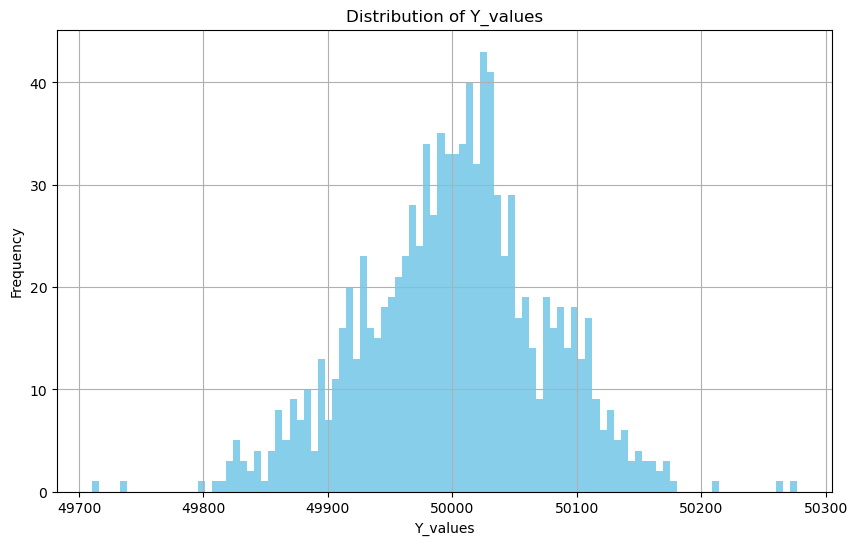

In [39]:
plt.figure(figsize=(10, 6))
plt.hist(Y_values, bins=100, color='skyblue')
plt.title('Distribution of Y_values')
plt.xlabel('Y_values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


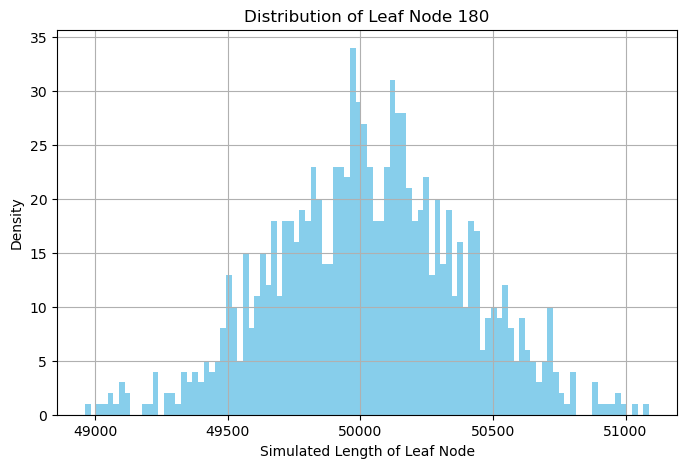

In [40]:
leaf_index = np.random.randint(0,203)  # Choose the index of the leaf node you want to analyze
leaf_data = X_values[:, leaf_index]  # Extract the column for this leaf

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(leaf_data, bins=100, color='skyblue')

# Add labels
plt.xlabel("Simulated Length of Leaf Node")
plt.ylabel("Density")
plt.grid(True)
plt.title(f"Distribution of Leaf Node {leaf_index}")

plt.show()

# Part II

#### Clique tree

In [41]:
def compute_pair_cliques(graph):
    C = nx.Graph()

    for edge in graph.edges:
        C.add_node(edge)

    return C

clique_tree = compute_pair_cliques(G)

print(clique_tree.number_of_nodes())

406


In [42]:
all_parents = tree["Parent"].unique()

# Find the leaf nodes (parents that do not appear in the 'Child' column)
leaf_nodes = [parent for parent in all_parents if parent not in tree["Child"].values]

In [43]:
def get_first_n_nodes(G, root, n):
    nodes = [root]
    current_level = [root]
    while len(nodes) < n:
        next_level = []
        for node in current_level:
            children = list(G.successors(node))
            next_level.extend(children)
            nodes.extend(children)
            if len(nodes) >= n:
                subgraph = G.subgraph(nodes[:n])
                mapping = {old_label: new_label for new_label, old_label in enumerate(subgraph.nodes())}
                return nx.relabel_nodes(subgraph, mapping)
        current_level = next_level
    subgraph = G.subgraph(nodes[:n])
    mapping = {old_label: new_label for new_label, old_label in enumerate(subgraph.nodes())}
    return nx.relabel_nodes(subgraph, mapping)

#### Gamma, beta, sigma, J and h

In [ ]:
def compute_gamma(G):
    # Initialize gamma as an identity matrix
    gamma = np.eye(len(G.nodes))

    # Iterate through the nodes
    for node in G.nodes:
        # Get the parent of the node (if exists)
        parent = next(G.predecessors(node), None)
        if parent is None:
            print(f"Node {node} is the root node")
            continue
        
        # Access the edge attribute 'b' for the edge from 'parent' to 'node'
        b = G[parent][node]['b']  # Access the edge (parent -> node) to get 'b'

        gamma[parent-1, node-1] = -b

    return gamma

def compute_beta():
    beta = np.zeros((len(G.nodes), 1))
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            continue
        a = G[parent][node]['a']
        beta[node-1] = G[parent][node]['a']
        
    return beta

def compute_sigma(G):
    sigma = np.zeros((len(G.nodes)))
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            # Assign the default value for the root node
            sigma[node - 1] = sigma_0_sq
        else:
            # Access the edge attribute 'variance' only if parent exists
            variance = G[parent][node]['variance']
            sigma[node - 1] = variance
    return sigma

beta = compute_beta(G)
sigma = compute_sigma(G)
gamma = compute_gamma(G)

def compute_J(gamma, sigma):
    J = np.zeros_like(gamma)
    
    # Iterate over each row in gamma
    for i in range(len(gamma)):
        # Get the i-th row (gamma_i) and the corresponding sigma_i
        gamma_i = gamma[i, :]
        sigma_i = sigma[i]
        
        # Compute the outer product of gamma_i with itself, scaled by 1/sigma_i^2 
        outer_product = np.outer(gamma_i, gamma_i) / (sigma_i) # MAYBE USE SIGMA_I^2
        
        # Add the outer product to the sum matrix
        J += outer_product
    
    return J

J = compute_J(gamma, sigma)
h = np.sum([(beta[i] / sigma[i]) * gamma[i] for i in range(len(G))], axis=0)

computed_covariance = np.linalg.inv(J)

computed_covariance

array([[ 2.25006250e+04,  1.80799239e-11,  2.79868159e-11, ...,
        -1.22236247e-11, -1.38431189e-11,  2.25006250e+04],
       [ 2.01065931e-11,  2.25006250e+04,  2.79868159e-11, ...,
        -1.22236247e-11, -1.38431189e-11,  2.25006250e+04],
       [ 2.76038761e-11,  2.81094938e-11,  3.04317657e+04, ...,
        -1.64319374e-11, -1.88834299e-11,  3.04317657e+04],
       ...,
       [-1.05435499e-11, -1.05072766e-11, -1.35905064e-11, ...,
         2.81250500e+04, -5.61284020e-11,  2.81250500e+04],
       [-1.20758436e-11, -1.20342028e-11, -1.55736742e-11, ...,
        -5.99072886e-11,  3.21547625e+04,  3.21547625e+04],
       [ 2.25006250e+04,  2.25006250e+04,  3.04317657e+04, ...,
         2.81250500e+04,  3.21547625e+04,  6.93838180e+06]])

#### Simulations for comparison

In [ ]:
# Number of simulations
n = 1000

def simulate_node_length(node, simulated_lengths):
    for child in G.successors(node):
        # parent_length = simulated_lengths[node]  # Get the parent's simulated value
        # t = G[node][child]['time']  # Time from parent to child
        # mean = alpha * t + beta * simulated_lengths[node] # Mean value for the child node
        a = G[node][child]['a']
        variance = G[node][child]['variance']
        
        # Simulate child node value
        simulated_lengths[child] = np.random.normal(a * simulated_lengths[node], np.sqrt(variance))
        
        # Recursively simulate for its children
        simulate_node_length(child, simulated_lengths)
    
    return simulated_lengths

def simulate_data(n):
    X_values = []
    Y_values = []
    
    all_nodes = list(G.nodes)  # Get all nodes in the graph

    for _ in range(n):
        simulated_lengths = {}
        
        # Simulate root node first
        simulated_lengths[root] = np.random.normal(alpha_0, np.sqrt(sigma_0_sq))
        
        # Simulate all other nodes recursively
        simulated_lengths = simulate_node_length(root, simulated_lengths)
        
        # Store all node values in order
        X_values.append([simulated_lengths[node] for node in all_nodes])
        Y_values.append(simulated_lengths[root])  # Root node as target
    
    return np.array(X_values), np.array(Y_values)

# Run simulation
X_values, Y_values = simulate_data(n)

# Print shapes to verify
print(X_values.shape)  # Should be (1000, total number of nodes)
print(Y_values.shape)  # Should be (1000,)


(1000, 407)
(1000,)


In [51]:
covariance = np.cov(X_values, rowvar=False)
J_estimate = np.linalg.inv(covariance)

print(covariance)

covariance

[[5.94855491e+04 2.12273443e+05 2.13606367e+05 ... 4.33928137e+02
  1.17831486e+04 8.33662899e+03]
 [2.12273443e+05 7.78270579e+05 7.63214396e+05 ... 1.92935409e+03
  3.93693812e+04 2.79302960e+04]
 [2.13606367e+05 7.63214396e+05 7.87843028e+05 ... 2.46916702e+03
  4.09128695e+04 2.91279098e+04]
 ...
 [4.33928137e+02 1.92935409e+03 2.46916702e+03 ... 1.25157757e+04
  1.67708752e+04 1.09897587e+04]
 [1.17831486e+04 3.93693812e+04 4.09128695e+04 ... 1.67708752e+04
  3.12612135e+05 2.05849431e+05]
 [8.33662899e+03 2.79302960e+04 2.91279098e+04 ... 1.09897587e+04
  2.05849431e+05 1.39766563e+05]]


array([[5.94855491e+04, 2.12273443e+05, 2.13606367e+05, ...,
        4.33928137e+02, 1.17831486e+04, 8.33662899e+03],
       [2.12273443e+05, 7.78270579e+05, 7.63214396e+05, ...,
        1.92935409e+03, 3.93693812e+04, 2.79302960e+04],
       [2.13606367e+05, 7.63214396e+05, 7.87843028e+05, ...,
        2.46916702e+03, 4.09128695e+04, 2.91279098e+04],
       ...,
       [4.33928137e+02, 1.92935409e+03, 2.46916702e+03, ...,
        1.25157757e+04, 1.67708752e+04, 1.09897587e+04],
       [1.17831486e+04, 3.93693812e+04, 4.09128695e+04, ...,
        1.67708752e+04, 3.12612135e+05, 2.05849431e+05],
       [8.33662899e+03, 2.79302960e+04, 2.91279098e+04, ...,
        1.09897587e+04, 2.05849431e+05, 1.39766563e+05]])

#### Conditional distributions

In [52]:
# Compute the conditional distribution of Z_0,...Z_n given X_0,...X_n

def compute_conditional_distribution(y, J, h, n):

    J_xx = J[:n, :n]
    J_xz = J[:n, n:]
    J_zx = J[n:, :n]
    J_zz = J[n:, n:]

    # print(J_xx.shape)
    # print(J_xz.shape)
    # print(J_zx.shape)
    # print(J_zz.shape)

    h_x = h[:n]
    h_z = h[n:]

    # print(h_z.shape) # Shape 203
    # print(J_xz.shape) # Shape 204, 203

    new_h = h_z - J_zx @ y

    # print(new_h.shape) # Shape 203

    return J_zz, new_h

y = np.ones(204)
conditional_J, conditional_h = compute_conditional_distribution(y,J,h, 204)


print(conditional_J[10][10])

7.91153450351181e-08


#### Clique Tree

In [ ]:
### Removes leaves from the original tree
def remove_leaves(G):
    # Create a copy of the graph to modify it while iterating
    H = G.copy()
    
    # Find all nodes with out-degree of 0 which are leaves
    leaves = [node for node in G.nodes() if G.out_degree(node) == 0]
    
    # Remove the identified leaf nodes
    H.remove_nodes_from(leaves)
    
    return H

G_no_leaves = remove_leaves(G)

# Creates junction tree
clique_tree = nx.junction_tree(G_no_leaves)

print((len(nx.nodes(clique_tree))))

# Adding new leaf nodes based on the second item of their parent's node tuple
leaf_nodes = [node for node in clique_tree.nodes() if clique_tree.degree(node) == 1]  # Identify leaf nodes
for leaf in leaf_nodes:
    if isinstance(leaf, tuple) and len(leaf) > 1:  # Check if the node is a tuple and has at least two elements
        new_leaf = (leaf[1],)  # Name the new leaf after the second item of the tuple
        clique_tree.add_node(new_leaf)
        clique_tree.add_edge(leaf, new_leaf)
        
### Completed junction tree nodes have output as a tuple. ex. (346,) if singleton node, (346, 347) if not singleton node
    
print(len(nx.nodes(clique_tree)))

clique_tree.nodes()
print(clique_tree.has_node((346,)))

# Define a layout for better spacing
pos = nx.kamada_kawai_layout(clique_tree)

# Draw the updated clique tree
plt.figure(figsize=(20, 20))
nx.draw(
    clique_tree, pos,
    with_labels=True,
    node_color="skyblue",
    node_size=100,
    edge_color="gray",
    width=1.5,
    font_size=6,
    font_color="black"
)
plt.show()

#### Message passing algorithm

In [ ]:
def compute_message_PTS(i, j, J, clique_tree, J_messages, h_messages):
    
    neighbors = list(clique_tree.neighbors(i))
    neighbors.remove(j)

    J_ji = J[j][i]
    J_ij = J[i][j]
    prev_J_message = J_messages[i][j]
    prev_h_message = h_messages[i]


    J_message = -np.dot(J_ji, J_ij) / prev_J_message
    h_message = -np.dot(J_ji, prev_h_message) / prev_J_message

    J_messages[i][j] = J_message
    h_messages[i] = h_message


def compute_message_STP(i, j, J, h, clique_tree, J_messages, h_messages):
    
    neighbors = list(clique_tree.neighbors(i))
    neighbors.remove(j)
    
    if neighbors is not None:
        J_sum = np.sum([J_messages[k][i] for k in neighbors])
        h_sum = np.sum([h_messages[k] for k in neighbors])

    J_hat_ij = J[i][i] + J_sum
    h_hat_ij = h[i] + h_sum

    J_messages[i][j] = J_hat_ij
    h_messages[i] = h_hat_ij

def upward_pass(clique_tree, J, h, root):
    
    flags = np.zeros(len(clique_tree.nodes))
    order = nx.dfs_postorder_nodes(clique_tree, source=root)
    J_messages = np.zeros(shape=J.shape)
    h_messages = np.zeros(shape=h.shape)

    for i in order:
        neighbors = list(clique_tree.neighbors(i))
        for j in neighbors:
            if flags[j] == 0:
                variables = clique_tree.nodes[i]['variables']
                if len(variables) == 2:
                    compute_message_PTS(i, j, J, clique_tree, J_messages, h_messages)
                else:
                    compute_message_STP(i, j, J, h, clique_tree, J_messages, h_messages)
                flags[j] = 1
            else:
                continue

    return J_messages, h_messages

def downward_pass(clique_tree, J, h, root, J_messages, h_messages):
    
    order = nx.dfs_preorder_nodes(clique_tree, source=root)
    flags = np.zeros(len(clique_tree.nodes))

    for i in order:
        neighbors = list(clique_tree.neighbors(i))
        for j in neighbors:
            if flags[j] == 0:
                variables = clique_tree.nodes[i]['variables']
                if len(variables) == 2:
                    compute_message_PTS(i, j, J, clique_tree, J_messages, h_messages)
                else:
                    compute_message_STP(i, j, J, h, clique_tree, J_messages, h_messages)
                flags[j] = 1
            else:
                continue

    return J_messages, h_messages

def compute_clique_beliefs(clique_tree, J, h, J_messages, h_messages):
    
    clique_j = np.zeros(shape=h.shape)
    clique_h = np.zeros(shape=h.shape)
    
    number_of_variables = len(h)
    for i in range(number_of_variables):
        J_i = J[i][i]
        h_i = h[i]

        for neighbor in clique_tree.neighbors(i):
            J_message = J_messages[neighbor][i]
            h_message = h_messages[neighbor]
            J_i += J_message
            h_i += h_message
        
        clique_j[i] = J_i
        clique_h[i] = h_i

    return clique_j, clique_h

def message_passing(J, h, clique_tree, root):
    
    J_messages_up, h_messages_up = upward_pass(clique_tree, J, h, root)
    J_messages_down, h_messages_down = downward_pass(clique_tree, J, h, root, J_messages_up, h_messages_up)
    clique_j, clique_h = compute_clique_beliefs(clique_tree, J, h, J_messages_down, h_messages_down)

    return clique_j, clique_h


clique_beliefs_J, clique_beliefs_h = message_passing(J, h, clique_tree, 406)


def informatioan_to_standard(J,h):
    covariance = np.linalg.inv(J)
    mean = np.dot(covariance,h)

    return mean, covariance

NetworkXError: The node 406 is not in the graph.

In [ ]:
def split_gene_data(df):

    unique_genes = df['orthId'].unique()
    length = len(unique_genes)
    print(unique_genes)
    gene_data = np.empty(length, dtype=object) 

    for i, gene in enumerate(unique_genes):
        data = df['glength'][df['orthId'] == gene].values
        print(f"Gene {gene} data: {data}")
        gene_data[i] = data

    return gene_data
        
    
result = split_gene_data(vert_genes)

result

['1CPN2' '1CQBX' '1CQJ6' '1CR8Z' '1CTEU' '1CTI9' '1CYBB' '1D0EM' '1D1CF'
 '1D3F1']
Gene 1CPN2 data: [ 66213  44913 157799  67073  95046  83890  88931   4238   4842 173713
  74387   5027  66520 102881 190050  66937   4265  72517 157660  27942
  76678  91108  69244  38257 171604 171302 203617   4242 147627   4112
  79105   4230  88182 187292   4239   5921  71367   4365  31630   4388
  89361  67824 126389   4568   4466  65704  73839 160601  68827 183361
  46699  68183 104007  48665   4250  68687   6731  31946  35820  18063
  26634  23210  12461  34159  19207  39627  39296  22154  22280  47566
  67539  27206 110726  20157  12183  30670  20712  28054  29584   3069
  20497  26695  62753   6240  44757  19611  26536  24159  29725  25090
  13570  78716 235072 249257  89073 271965 271860 269890 271513 257735
  83787  83975  78545 248947  99244 105538 227106 253796  88628 256326
 233329 258535 353701 257320  86249  89972  95274 221963 302664 370084
 108205 240821 234204  90005 129820  90485 22790

array([array([ 66213,  44913, 157799,  67073,  95046,  83890,  88931,   4238,
                4842, 173713,  74387,   5027,  66520, 102881, 190050,  66937,
                4265,  72517, 157660,  27942,  76678,  91108,  69244,  38257,
              171604, 171302, 203617,   4242, 147627,   4112,  79105,   4230,
               88182, 187292,   4239,   5921,  71367,   4365,  31630,   4388,
               89361,  67824, 126389,   4568,   4466,  65704,  73839, 160601,
               68827, 183361,  46699,  68183, 104007,  48665,   4250,  68687,
                6731,  31946,  35820,  18063,  26634,  23210,  12461,  34159,
               19207,  39627,  39296,  22154,  22280,  47566,  67539,  27206,
              110726,  20157,  12183,  30670,  20712,  28054,  29584,   3069,
               20497,  26695,  62753,   6240,  44757,  19611,  26536,  24159,
               29725,  25090,  13570,  78716, 235072, 249257,  89073, 271965,
              271860, 269890, 271513, 257735,  83787,  83975,  7

#### Elimination order

In [ ]:
def elimination_order(G):
    # Find the root (the only node with in-degree 0)
    root = [node for node in G.nodes if G.in_degree(node) == 0][0]
    
    # Compute depth (distance from root)
    depths = nx.shortest_path_length(G, source=root)
    
    # Sort nodes by depth in descending order
    ordered_nodes = sorted(depths.keys(), key=lambda node: depths[node], reverse=True)
    
    return ordered_nodes

elimination_order(G)